## This notebook can be used for generation of tracks for simulation as .world files for Webots. Tracks are generated from trajectory defined as sequence of points in .csv file (columns are ["x_m", "y_m", "w_tr_right_m", "w_tr_left_m"]) placed in "tracks" folder.

D 8.1.1 The trackdrive layout is a closed loop circuit built to the following guidelines:

* Straights: No longer than 80 m
* Constant Turns: up to 50 m diameter
* Hairpin Turns: Minimum of 9 m outside diameter (of the turn)
* Miscellaneous: Chicanes, multiple turns, decreasing radius turns, etc.
* The minimum track width is 3 m

D 8.1.2 The length of one lap is approximately 200 m to 500 m.

Handbook:
* Distance between cones is up to 5 m

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
TRAJECTORY_FILES_PATH = "tracks"
WEBOTS_WORLD_FILE_PATH = "Webots environment/worlds"

### Let's see available trajectories

##### Load real track trajectories

In [3]:
track_trajectory_files = os.listdir(TRAJECTORY_FILES_PATH)
track_trajectory_files

['handling_track.csv',
 'berlin_2018.csv',
 'modena_2019.csv',
 'rounded_rectangle.csv']

##### Visualize trajectories

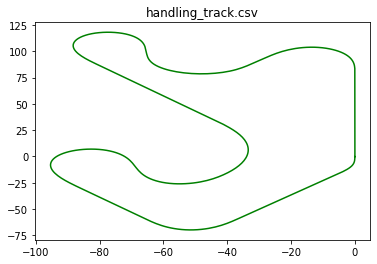

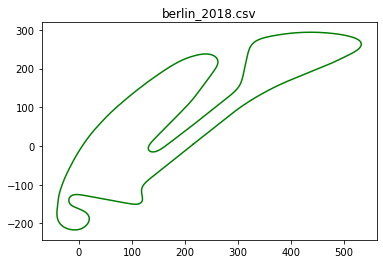

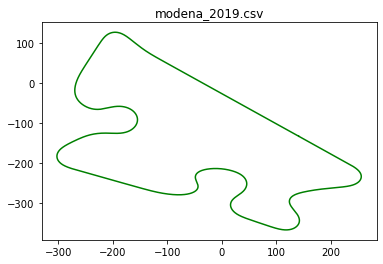

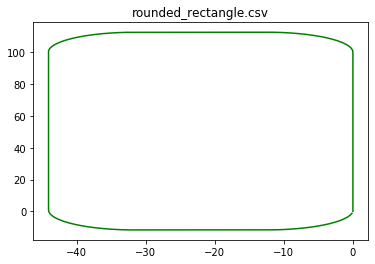

In [4]:
for file in track_trajectory_files:
    track_points = pd.read_csv(os.path.join(TRAJECTORY_FILES_PATH, file))
    X = track_points["x_m"].values
    Y = track_points["y_m"].values
    plt.figure()
    plt.title(file)
    plt.plot(X, Y, "g")
    plt.show()

## Variables to define:

In [5]:
# Trajectory file (input)
track_trajectory_file = os.path.join(TRAJECTORY_FILES_PATH, 'berlin_2018.csv')
track_trajectory_file = os.path.join(TRAJECTORY_FILES_PATH, 'rounded_rectangle.csv')
# Where to save world (output)
world_filename = os.path.join(WEBOTS_WORLD_FILE_PATH, "generated_track.wbt")

track_trajectory_file, world_filename

('tracks/rounded_rectangle.csv',
 'Webots environment/worlds/generated_track.wbt')

### Load trajectory

##### Load first track trajectory

In [6]:
track_points = pd.read_csv(track_trajectory_file)
X = track_points["x_m"].values
Y = track_points["y_m"].values
width_left = track_points["w_tr_left_m"].values
width_right = track_points["w_tr_right_m"].values

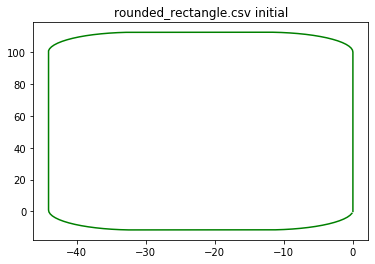

In [7]:
plt.figure()
plt.title(file + " initial")
plt.plot(X, Y, "g")
plt.show()

##### Center track

In [8]:
def center_track(X, Y):
    """Moves track such that it's center is at (0, 0) coordinates"""
    mean_X = (np.max(X) + np.min(X)) / 2
    mean_Y = (np.max(Y) + np.min(Y)) / 2
    X_centered = [x - mean_X for x in X]
    Y_centered = [y - mean_Y for y in Y]
    
    return X_centered, Y_centered

In [9]:
X, Y = center_track(X, Y)

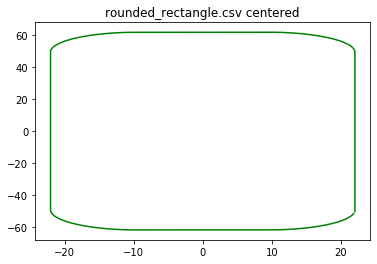

In [10]:
plt.figure()
plt.title(file + " centered")
plt.plot(X, Y, "g")
plt.show()

### Transform trajectories to cone positions

##### Get cone positions

In [11]:
def get_cone_positions(track_X, track_Y):
    left_X, left_Y = [], [] # left border of track
    right_X, right_Y = [], []

    for i in range(len(track_X)):
        # Vector to cone is direction vector rotated on 90 degrees clockwise
        dir_vec = (track_X[i] - track_X[i-1], track_Y[i] - track_Y[i-1])
        cone_vec = (-dir_vec[1], dir_vec[0])
        cone_vec = [el / np.sqrt(cone_vec[0] ** 2 + cone_vec[1] **2) for el in cone_vec]# Normalize vector

        # Compute track borders
        left_point = (track_X[i-1] + cone_vec[0] * width_left[i-1], track_Y[i-1] + cone_vec[1] * width_left[i-1])
        right_point = (track_X[i-1] - cone_vec[0] * width_right[i-1], track_Y[i-1] - cone_vec[1] * width_right[i-1])

        left_X.append(left_point[0])
        left_Y.append(left_point[1])
        right_X.append(right_point[0])
        right_Y.append(right_point[1])
    return left_X, left_Y, right_X, right_Y

In [12]:
left_X, left_Y, right_X, right_Y = get_cone_positions(X, Y)

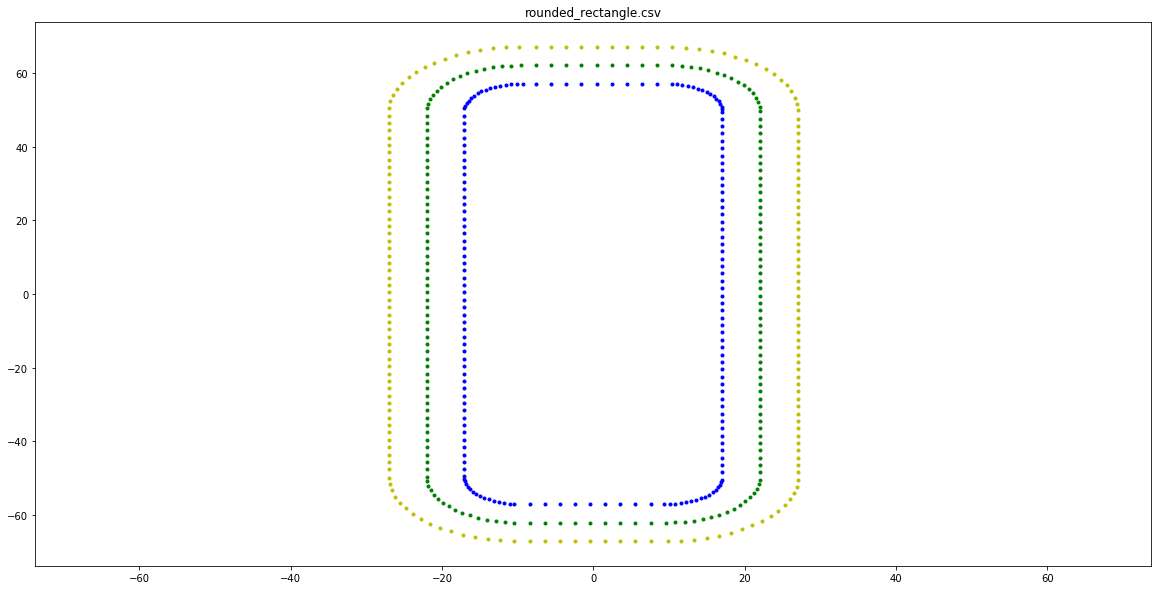

In [13]:
# start, end = 300, 500
start, end = 0, len(left_X) + 1

plt.figure(figsize=(20, 10))
plt.title(file)
max_coord = max([abs(coord) for coord in X + Y + left_X + left_Y + right_X + right_Y]) * 1.1
plt.xlim(-max_coord, max_coord)
plt.ylim(-max_coord, max_coord)
plt.plot(X[start:end], Y[start:end], "g.")
plt.plot(left_X[start:end], left_Y[start:end], "b.")
plt.plot(right_X[start:end], right_Y[start:end], "y.")
# plt.plot(X[0], Y[0], "g*")
# plt.plot(X[70], Y[70], "g*")
plt.show()

##### Filter cones

In [14]:
# According to rules there is 5m distance between cones
def filter_cones(X, Y, dist_between_cones):
    """Filter cones to have particular distance between them."""
    def l2_dist(point1, point2):
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    last_XY = (X[0], Y[0])
    X_distanced = [X[0]] # Take first point
    Y_distanced = [Y[0]]

    for i, (x, y) in enumerate(zip(X[1:], Y[1:])):
        if l2_dist(last_XY, (x, y)) > dist_between_cones:
            X_distanced.append(x)
            Y_distanced.append(y)
            last_XY = (x, y)
            
    return X_distanced, Y_distanced

In [15]:
dist_between_cones = 5 # m

initial_n_left = len(left_X)
initial_n_right = len(right_X)

left_X, left_Y = filter_cones(left_X, left_Y, dist_between_cones)
right_X, right_Y = filter_cones(right_X, right_Y, dist_between_cones)

print(f"Reduced number of cones from {initial_n_left} to {len(left_X)} on the left"
      f"and from {initial_n_right} to {len(right_X)} on the right")

Reduced number of cones from 180 to 48 on the leftand from 180 to 60 on the right


### Save world

##### Load templates for world file

In [16]:
f = open("base_world_data_template.txt", "r")
base_world_data_template = f.read()

In [17]:
f = open("robot_structure_template.txt", "r")
robot_structure_template = f.read()

In [18]:
cones_prefix_template = """Transform {
  scale {} {} {}
  children [
"""
cones_postfix = """  ]
}
"""
cone_template = """    TrafficCone {
      translation {} 0 {}
      name "{} cone({})"
      physics Physics {
      }
    }
"""

##### Fill templates

In [19]:
# To make track not be near border of floor
max_width = max(width_left + width_right)
floor_size_X = (max([abs(x) for x in X]) + max_width) * 1.1 * 2 
floor_size_Y = (max([abs(y) for y in Y]) + max_width) * 1.1 * 2
floor_size_X, floor_size_Y

(70.4924, 158.49460000000002)

In [20]:
base_world_data = base_world_data_template.replace("{}", str(floor_size_X), 1)\
                                          .replace("{}", str(floor_size_Y), 1)

In [21]:
track_start_X = (right_X[0] + left_X[0]) / 2
track_start_Y = (left_Y[0] + right_Y[0]) / 2

robot_structure = robot_structure_template.replace("{}", str(track_start_X), 1)\
                                          .replace("{}", str(track_start_Y), 1)

In [22]:
# Webots cones are bigger than the ones stated in the rules
CONES_SCALE = 0.5

cones_prefix = cones_prefix_template.replace("{}", str(CONES_SCALE), 3)

In [23]:
cones = []

for cone_color, X, Y in [("Blue", left_X, left_Y), ("Yellow", right_X, right_Y)]:
    cones.extend([cone_template.replace("{}", str(x / CONES_SCALE), 1).replace("{}", str(y / CONES_SCALE), 1)\
                               .replace("{}", cone_color, 1).replace("{}", str(i), 1)
                 for i, (x, y) in enumerate(zip(X, Y))])

In [24]:
with open(world_filename, "w") as f:
    f.write(base_world_data)
    f.write(robot_structure)
    f.write(cones_prefix)
    for cone in cones:
        f.write(cone)
    f.write(cones_postfix)

### Save cone coordinates

In [25]:
# Doing this for precise cone position extraction for perception purposes

In [26]:
# Blue cones on left, Yellow on right (Handbook). In Webots "y" axis goes up, so we use "z" axis instead
data = {"color": ["blue"] * len(left_X) + ["yellow"] * len(right_X),
        "x": left_X + right_X,
        "z": left_Y + right_Y}

In [27]:
cones_coordinates = pd.DataFrame(data)

In [28]:
cones_coordinates.to_csv("cone_coordinates.csv", index=False)